<a href="https://colab.research.google.com/github/dougyd92/ML-Foudations/blob/main/Notebooks/7_Tree_Based_Methods_and_Ensemble_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tree-Based Methods and Ensemble Learning

---



In this notebook, we'll explore **decision trees** and **ensemble methods** — powerful techniques that combine multiple models to achieve better performance than any single model alone.

**Topics covered:**
1. Building and visualizing decision trees
2. Understanding overfitting and pruning
3. Bagging and Random Forests
4. Boosting methods (AdaBoost, Gradient Boosting, XGBoost)
5. Feature importance analysis

## Setup and Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_covtype, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier
)
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Setup complete! All libraries imported successfully.")

Setup complete! All libraries imported successfully.


## Load and Prepare the Dataset

We'll use the **Forest Covertype** dataset — a real-world classification problem where we predict the type of forest cover based on cartographic variables like elevation, slope, and soil type.

In [ ]:
# Note: This is a BIG dataset. It may take 1-2 minutes to load

# Load the Forest Covertype dataset
covtype = fetch_covtype()

# Define meaningful target names
target_names = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine',
                'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']

print(f"Dataset: Forest Covertype Classification")
print(f"Total samples: {covtype.data.shape[0]:,}")
print(f"Features: {covtype.data.shape[1]}")
print(f"Classes: {len(target_names)}")
print(f"\nTarget classes:")
for i, name in enumerate(target_names):
    print(f"  {i}: {name}")

Dataset: Forest Covertype Classification
Total samples: 581,012
Features: 54
Classes: 7

Target classes:
  0: Spruce/Fir
  1: Lodgepole Pine
  2: Ponderosa Pine
  3: Cottonwood/Willow
  4: Aspen
  5: Douglas-fir
  6: Krummholz


In [ ]:
# The dataset is large (580K+ samples), so we'll use a smaller subset for faster computation
n_samples = 20000
indices = np.random.choice(covtype.data.shape[0], n_samples, replace=False)
X = covtype.data[indices]
y = covtype.target[indices] - 1  # Convert to 0-indexed

feature_names = covtype.feature_names

print(f"Working with {n_samples:,} samples")
print(f"\nClass distribution:")
for i, name in enumerate(target_names):
    count = np.sum(y == i)
    print(f"  {name}: {count} ({count/len(y)*100:.1f}%)")

Working with 20,000 samples

Class distribution:
  Spruce/Fir: 7365 (36.8%)
  Lodgepole Pine: 9725 (48.6%)
  Ponderosa Pine: 1207 (6.0%)
  Cottonwood/Willow: 85 (0.4%)
  Aspen: 317 (1.6%)
  Douglas-fir: 627 (3.1%)
  Krummholz: 674 (3.4%)


In [ ]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")

Training set: 14,000 samples
Test set: 6,000 samples


---
# Section 1: Decision Tree Basics

## Building a Simple Decision Tree

Let's start by training a shallow decision tree (max_depth=3) so we can visualize its structure.

In [ ]:
# Train a simple decision tree with limited depth
dt_simple = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_simple.fit(X_train, y_train)

# Evaluate
train_acc = dt_simple.score(X_train, y_train)
test_acc = dt_simple.score(X_test, y_test)

print(f"Simple Decision Tree (max_depth=3):")
print(f"  Training accuracy: {train_acc:.3f}")
print(f"  Test accuracy: {test_acc:.3f}")

Simple Decision Tree (max_depth=3):
  Training accuracy: 0.676
  Test accuracy: 0.682


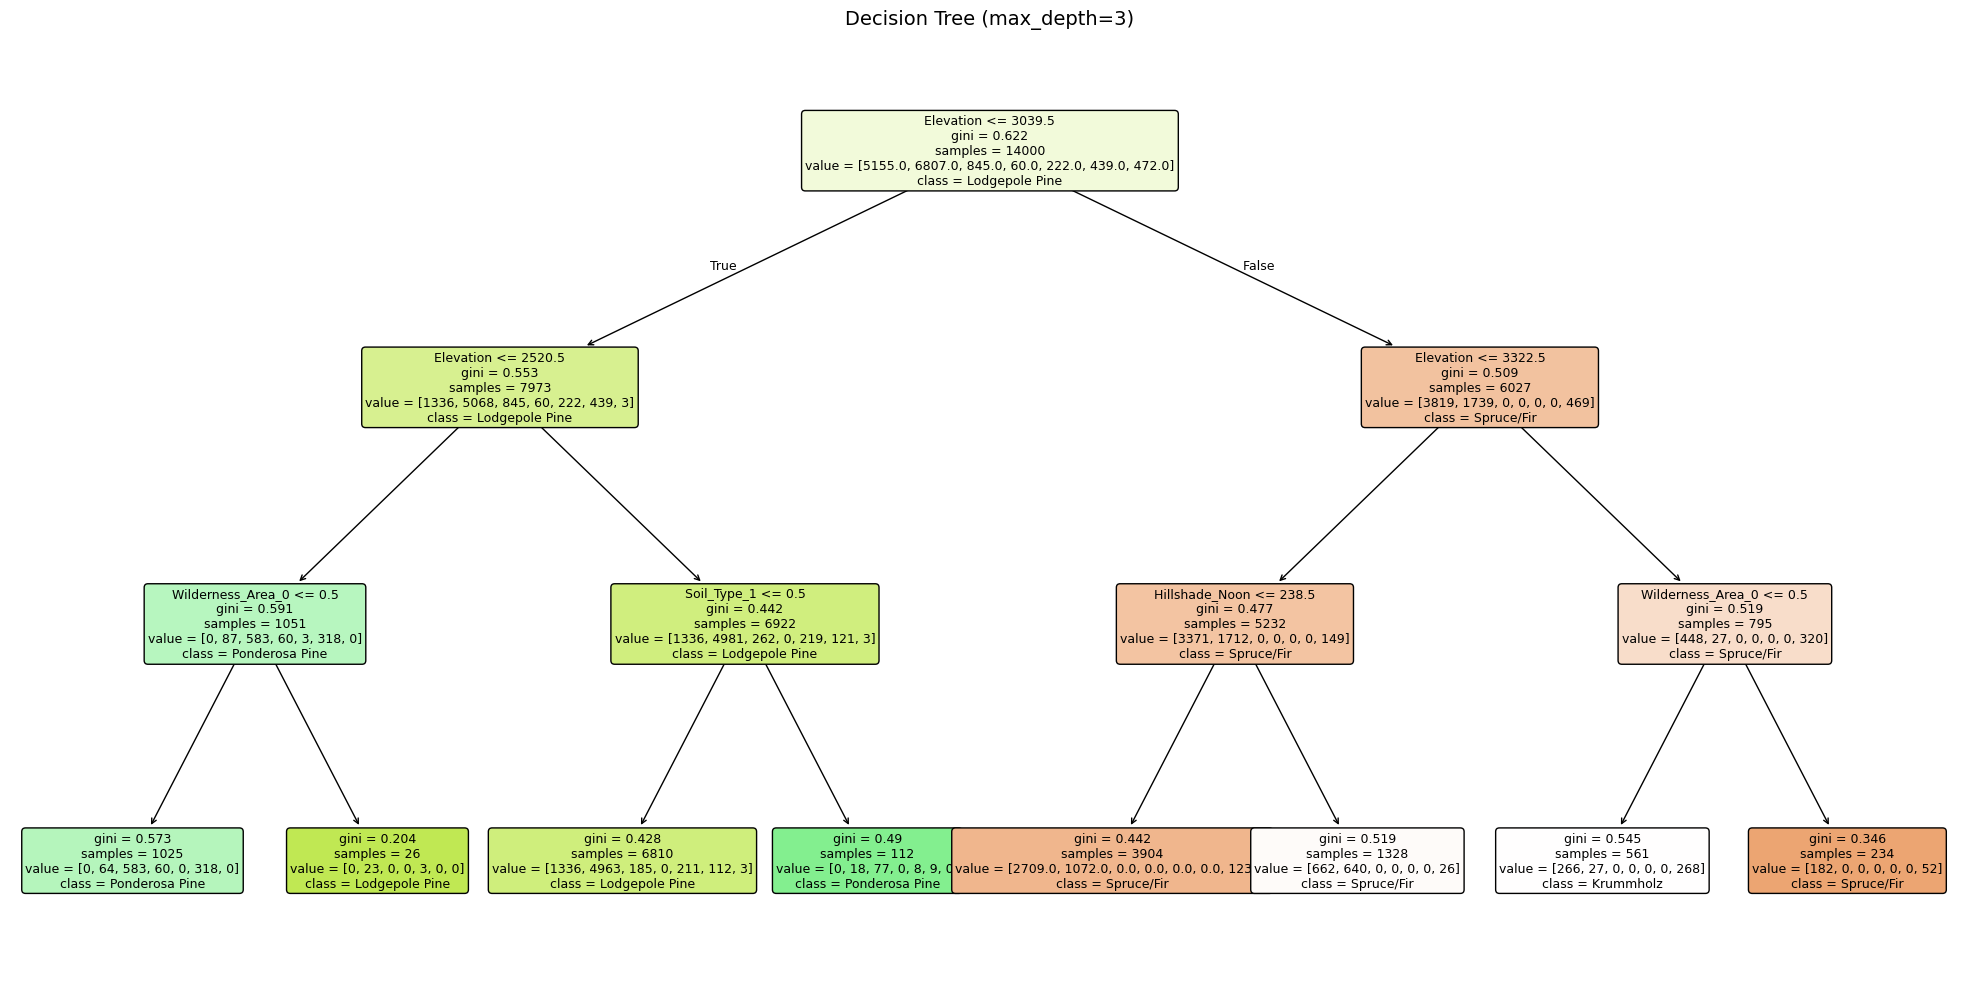

In [ ]:
# Visualize the tree structure
plt.figure(figsize=(20, 10))
plot_tree(dt_simple,
          feature_names=feature_names,
          class_names=target_names,
          filled=True,
          rounded=True,
          fontsize=9)
plt.title('Decision Tree (max_depth=3)', fontsize=14)
plt.tight_layout()
plt.show()

---
# Section 2: Overfitting and Pruning

## The Overfitting Problem

Decision trees can easily overfit by growing too deep. Let's see how training and test accuracy change with tree depth.

In [ ]:
# Compare trees of different depths
depths = range(1, 31)
train_scores = []
test_scores = []

for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    train_scores.append(dt.score(X_train, y_train))
    test_scores.append(dt.score(X_test, y_test))

# Find optimal depth
best_depth = depths[np.argmax(test_scores)]
best_test_acc = max(test_scores)

print(f"Optimal tree depth: {best_depth}")
print(f"Best test accuracy: {best_test_acc:.3f}")

Optimal tree depth: 20
Best test accuracy: 0.758


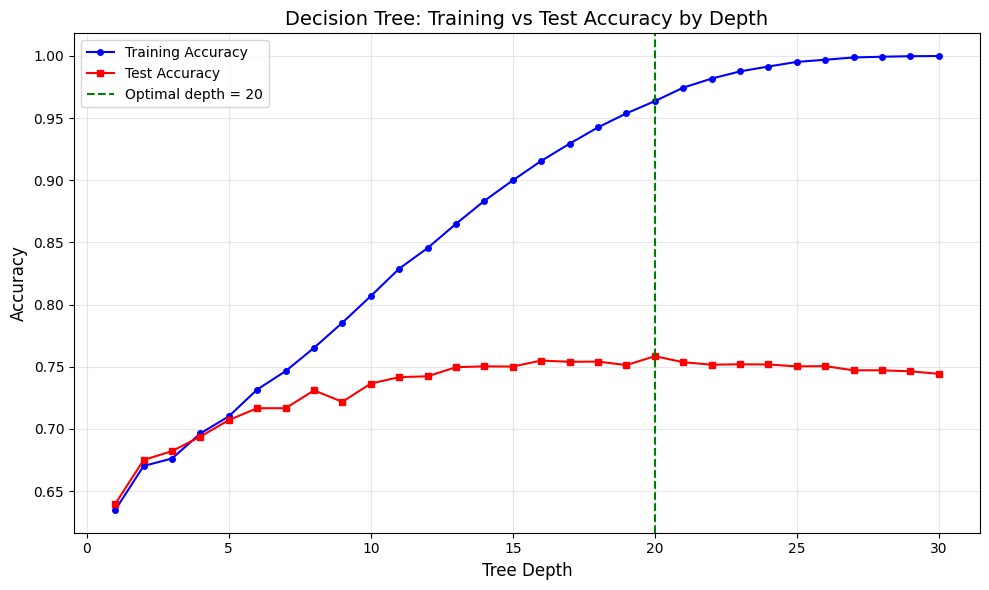


Observation: Training accuracy keeps increasing, but test accuracy
plateaus and may decrease — this is OVERFITTING!


In [ ]:
# Visualize overfitting
plt.figure(figsize=(10, 6))
plt.plot(depths, train_scores, 'b-o', label='Training Accuracy', markersize=4)
plt.plot(depths, test_scores, 'r-s', label='Test Accuracy', markersize=4)
plt.axvline(x=best_depth, color='green', linestyle='--',
            label=f'Optimal depth = {best_depth}')
plt.xlabel('Tree Depth', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Decision Tree: Training vs Test Accuracy by Depth', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nObservation: Training accuracy keeps increasing, but test accuracy")
print("plateaus and may decrease — this is OVERFITTING!")

## Pruning: Controlling Tree Complexity

We can prevent overfitting using **hyperparameters** that limit tree growth:
- `max_depth`: Maximum depth of the tree
- `min_samples_split`: Minimum samples required to split a node
- `min_samples_leaf`: Minimum samples required in a leaf node

In [ ]:
# Train a pruned tree with multiple constraints
dt_pruned = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)
dt_pruned.fit(X_train, y_train)

print(f"Pruned Decision Tree:")
print(f"  Actual depth: {dt_pruned.tree_.max_depth}")
print(f"  Number of leaves: {dt_pruned.tree_.n_leaves}")
print(f"  Training accuracy: {dt_pruned.score(X_train, y_train):.3f}")
print(f"  Test accuracy: {dt_pruned.score(X_test, y_test):.3f}")

Pruned Decision Tree:
  Actual depth: 10
  Number of leaves: 265
  Training accuracy: 0.783
  Test accuracy: 0.732


## EXERCISE 1: Pruning with Hyperparameters

Your task: Train a decision tree with the following constraints to prevent overfitting:
1. max_depth = 5
2. min_samples_split = 20
3. min_samples_leaf = 10

Then evaluate it on the test set and compare to an unpruned tree.

In [ ]:
# 1. Create a pruned decision tree with the specified parameters

# Write your code here


In [ ]:
#@title Click to reveal solution.

# 1. Create a pruned decision tree with the specified parameters
dt_exercise = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)
dt_exercise.fit(X_train, y_train)

print("Pruned tree created!")

Pruned tree created!


In [ ]:
# 2. Evaluate on the test set

# Write your code here


In [ ]:
#@title Click to reveal solution.

# 2. Evaluate on the test set
train_acc_ex = dt_exercise.score(X_train, y_train)
test_acc_ex = dt_exercise.score(X_test, y_test)

print(f"Pruned tree (max_depth=5):")
print(f"  Training accuracy: {train_acc_ex:.3f}")
print(f"  Test accuracy: {test_acc_ex:.3f}")
print(f"  Train-test gap: {train_acc_ex - test_acc_ex:.3f}")

Pruned tree (max_depth=5):
  Training accuracy: 0.710
  Test accuracy: 0.707
  Train-test gap: 0.002


In [ ]:
# 3. Compare to an unpruned tree

# Write your code here


In [ ]:
#@title Click to reveal solution.

# 3. Compare to an unpruned tree
dt_unpruned = DecisionTreeClassifier(random_state=42)
dt_unpruned.fit(X_train, y_train)

train_acc_unpruned = dt_unpruned.score(X_train, y_train)
test_acc_unpruned = dt_unpruned.score(X_test, y_test)

print(f"Unpruned tree:")
print(f"  Actual depth: {dt_unpruned.tree_.max_depth}")
print(f"  Training accuracy: {train_acc_unpruned:.3f}")
print(f"  Test accuracy: {test_acc_unpruned:.3f}")
print(f"  Train-test gap: {train_acc_unpruned - test_acc_unpruned:.3f}")

print(f"\nComparison:")
print(f"  Pruned test accuracy: {test_acc_ex:.3f}")
print(f"  Unpruned test accuracy: {test_acc_unpruned:.3f}")
print(f"\nObservation: The unpruned tree has a much larger train-test gap,")
print(f"indicating overfitting. Pruning helps reduce this gap!")

Unpruned tree:
  Actual depth: 31
  Training accuracy: 1.000
  Test accuracy: 0.743
  Train-test gap: 0.257

Comparison:
  Pruned test accuracy: 0.707
  Unpruned test accuracy: 0.743

Observation: The unpruned tree has a much larger train-test gap,
indicating overfitting. Pruning helps reduce this gap!


---
# Section 3: Feature Importance

## Understanding Feature Importance

Decision trees provide a natural measure of feature importance based on how much each feature reduces impurity (Gini or entropy) across all splits.

In [ ]:
# Get feature importances from the pruned tree
importances = dt_pruned.feature_importances_
indices = np.argsort(importances)[::-1]

# Show top 15 features
print("Top 15 Most Important Features:")
print("=" * 45)
for i in range(15):
    print(f"{i+1:2d}. {feature_names[indices[i]]:30s}: {importances[indices[i]]:.4f}")

Top 15 Most Important Features:
 1. Elevation                     : 0.5722
 2. Horizontal_Distance_To_Fire_Points: 0.0634
 3. Horizontal_Distance_To_Roadways: 0.0553
 4. Horizontal_Distance_To_Hydrology: 0.0385
 5. Hillshade_Noon                : 0.0342
 6. Vertical_Distance_To_Hydrology: 0.0279
 7. Wilderness_Area_0             : 0.0250
 8. Soil_Type_1                   : 0.0204
 9. Soil_Type_3                   : 0.0199
10. Hillshade_9am                 : 0.0188
11. Soil_Type_21                  : 0.0180
12. Soil_Type_22                  : 0.0177
13. Aspect                        : 0.0160
14. Hillshade_3pm                 : 0.0108
15. Soil_Type_31                  : 0.0108


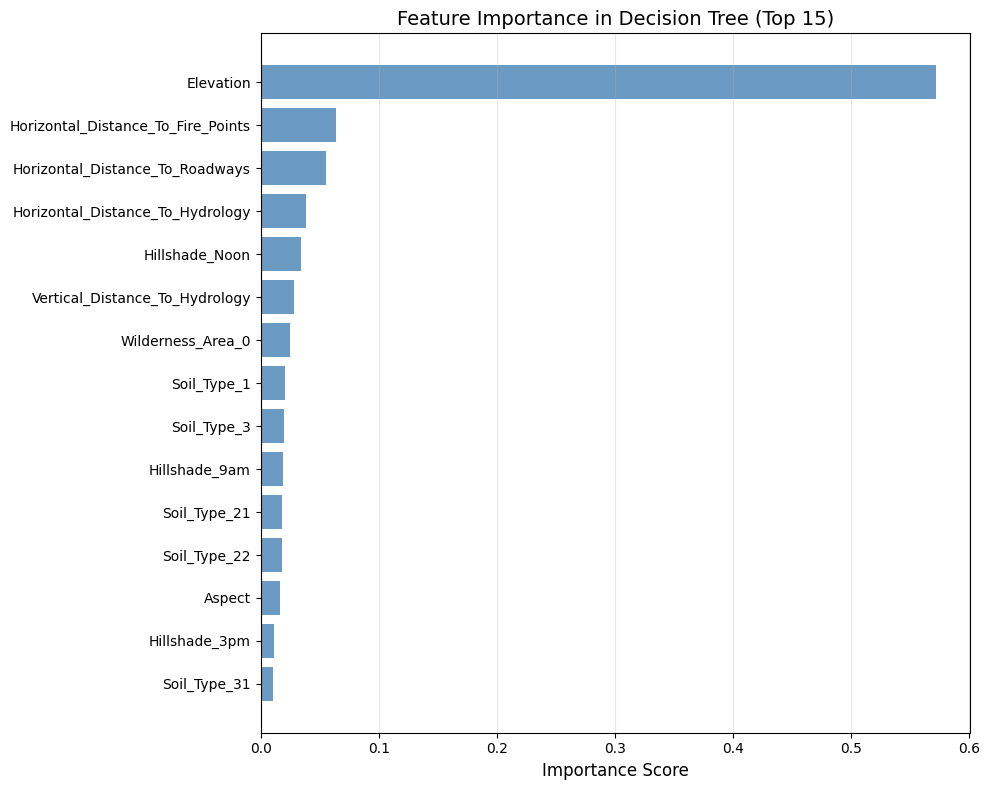

In [ ]:
# Visualize feature importances (top 15)
top_n = 15
top_indices = indices[:top_n]

plt.figure(figsize=(10, 8))
plt.barh(range(top_n), importances[top_indices], color='steelblue', alpha=0.8)
plt.yticks(range(top_n), [feature_names[i] for i in top_indices])
plt.xlabel('Importance Score', fontsize=12)
plt.title('Feature Importance in Decision Tree (Top 15)', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

---
# Section 4: Bagging and Random Forests

## Ensemble Methods: The Power of Combining Trees

**Bagging** (Bootstrap Aggregating) trains multiple trees on different bootstrap samples and averages their predictions. **Random Forests** extend this by also randomizing feature selection at each split.

**Key benefits:**
- Reduces variance (overfitting)
- More stable predictions
- Better generalization

In [ ]:
# Single decision tree (baseline)
dt_full = DecisionTreeClassifier(random_state=42)
dt_full.fit(X_train, y_train)

print(f"Single Decision Tree:")
print(f"  Depth: {dt_full.tree_.max_depth}")
print(f"  Training accuracy: {dt_full.score(X_train, y_train):.3f}")
print(f"  Test accuracy: {dt_full.score(X_test, y_test):.3f}")

Single Decision Tree:
  Depth: 31
  Training accuracy: 1.000
  Test accuracy: 0.743


In [ ]:
# Bagging Classifier
bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=20),
    n_estimators=100,
    max_samples=0.8,
    random_state=42,
    n_jobs=-1
)
bagging.fit(X_train, y_train)

print(f"\nBagging (100 trees):")
print(f"  Training accuracy: {bagging.score(X_train, y_train):.3f}")
print(f"  Test accuracy: {bagging.score(X_test, y_test):.3f}")


Bagging (100 trees):
  Training accuracy: 0.979
  Test accuracy: 0.820


In [ ]:
# Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

print(f"\nRandom Forest (100 trees):")
print(f"  Training accuracy: {rf.score(X_train, y_train):.3f}")
print(f"  Test accuracy: {rf.score(X_test, y_test):.3f}")


Random Forest (100 trees):
  Training accuracy: 0.965
  Test accuracy: 0.808


In [ ]:
# Compare all methods so far
print("\n" + "="*50)
print("COMPARISON: Single Tree vs Ensemble Methods")
print("="*50)

models = {
    'Single Tree': dt_full,
    'Bagging (100 trees)': bagging,
    'Random Forest (100 trees)': rf
}

for name, model in models.items():
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    print(f"{name:28s}: Train = {train_acc:.3f}, Test = {test_acc:.3f}")


COMPARISON: Single Tree vs Ensemble Methods
Single Tree                 : Train = 1.000, Test = 0.743
Bagging (100 trees)         : Train = 0.979, Test = 0.820
Random Forest (100 trees)   : Train = 0.965, Test = 0.808


## How Many Trees Do We Need?

Let's see how accuracy changes as we add more trees to the forest.

In [ ]:
# Track accuracy vs number of estimators
n_estimators_range = [1, 5, 10, 20, 50, 100, 150, 200]
rf_train_scores = []
rf_test_scores = []

for n_est in n_estimators_range:
    rf_temp = RandomForestClassifier(n_estimators=n_est, max_depth=20,
                                      random_state=42, n_jobs=-1)
    rf_temp.fit(X_train, y_train)
    rf_train_scores.append(rf_temp.score(X_train, y_train))
    rf_test_scores.append(rf_temp.score(X_test, y_test))
    print(f"n_estimators = {n_est:3d}: Test accuracy = {rf_test_scores[-1]:.3f}")

n_estimators =   1: Test accuracy = 0.682
n_estimators =   5: Test accuracy = 0.768
n_estimators =  10: Test accuracy = 0.790
n_estimators =  20: Test accuracy = 0.803
n_estimators =  50: Test accuracy = 0.804
n_estimators = 100: Test accuracy = 0.808
n_estimators = 150: Test accuracy = 0.805
n_estimators = 200: Test accuracy = 0.805


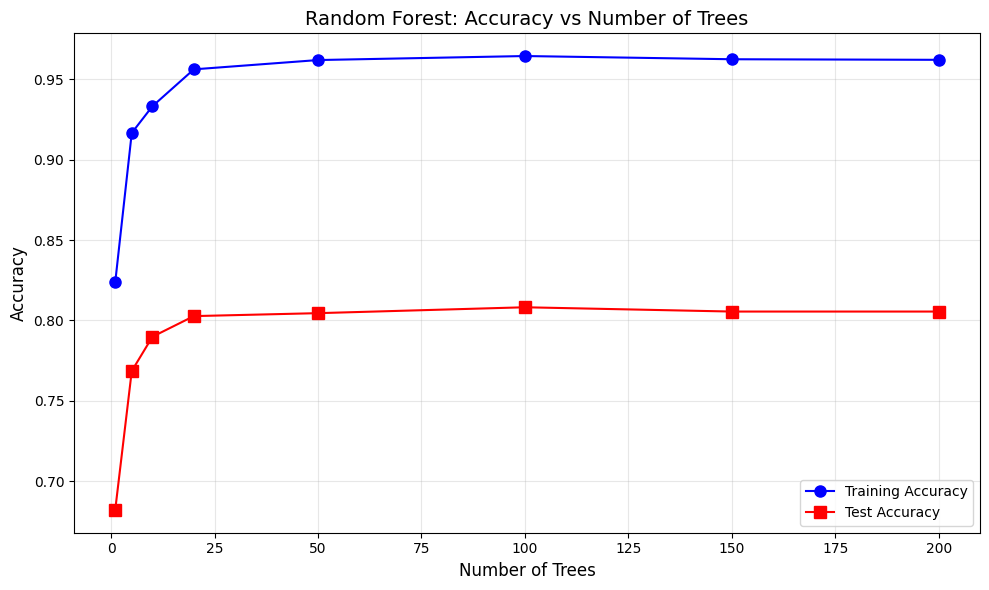


Observation: Test accuracy improves quickly at first, then plateaus.
Adding more trees beyond a certain point has diminishing returns.


In [ ]:
# Visualize
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, rf_train_scores, 'b-o', label='Training Accuracy', markersize=8)
plt.plot(n_estimators_range, rf_test_scores, 'r-s', label='Test Accuracy', markersize=8)
plt.xlabel('Number of Trees', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Random Forest: Accuracy vs Number of Trees', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nObservation: Test accuracy improves quickly at first, then plateaus.")
print("Adding more trees beyond a certain point has diminishing returns.")

## EXERCISE 2: Random Forest Hyperparameter Tuning

Your task: Experiment with different Random Forest hyperparameters to find the best configuration.

Try at least 3 different configurations varying:
- `n_estimators`: Number of trees (try 50, 100, 200)
- `max_depth`: Maximum tree depth (try 10, 20, None)
- `max_features`: Features to consider at each split (try 'sqrt', 'log2', None)

In [ ]:
# 1. Try at least 3 different Random Forest configurations

# Write your code here


In [ ]:
#@title Click to reveal solution.

# 1. Try different Random Forest configurations
configs = [
    {'n_estimators': 50, 'max_depth': 10, 'max_features': 'sqrt'},
    {'n_estimators': 100, 'max_depth': 20, 'max_features': 'sqrt'},
    {'n_estimators': 100, 'max_depth': None, 'max_features': 'log2'},
    {'n_estimators': 200, 'max_depth': 20, 'max_features': None},
]

results = []
print("Random Forest Hyperparameter Comparison:")
print("=" * 70)

for config in configs:
    rf_test = RandomForestClassifier(random_state=42, n_jobs=-1, **config)
    rf_test.fit(X_train, y_train)

    train_acc = rf_test.score(X_train, y_train)
    test_acc = rf_test.score(X_test, y_test)

    results.append({
        'config': config,
        'train_acc': train_acc,
        'test_acc': test_acc
    })

    print(f"n_est={config['n_estimators']:3d}, depth={str(config['max_depth']):4s}, "
          f"features={str(config['max_features']):5s} → "
          f"Train: {train_acc:.3f}, Test: {test_acc:.3f}")

Random Forest Hyperparameter Comparison:
n_est= 50, depth=10  , features=sqrt  → Train: 0.790, Test: 0.742
n_est=100, depth=20  , features=sqrt  → Train: 0.965, Test: 0.808
n_est=100, depth=None, features=log2  → Train: 1.000, Test: 0.821
n_est=200, depth=20  , features=None  → Train: 0.984, Test: 0.826


In [ ]:
# 2. Find the best configuration

# Write your code here


In [ ]:
#@title Click to reveal solution.

# 2. Find the best configuration
best_result = max(results, key=lambda x: x['test_acc'])

print("\nBest Configuration:")
print(f"  {best_result['config']}")
print(f"  Test accuracy: {best_result['test_acc']:.3f}")


Best Configuration:
  {'n_estimators': 200, 'max_depth': 20, 'max_features': None}
  Test accuracy: 0.826


---
# Section 5: Boosting Methods

## Boosting: Sequential Learning

Unlike bagging (which trains trees independently), **boosting** trains trees sequentially, with each tree focusing on the mistakes of previous trees.

**Key boosting algorithms:**
- **AdaBoost**: Adjusts sample weights based on misclassifications
- **Gradient Boosting**: Fits trees to the residual errors
- **XGBoost**: Optimized gradient boosting with regularization

In [ ]:
# AdaBoost
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3),
    n_estimators=100,
    learning_rate=0.5,
    random_state=42
)
ada.fit(X_train, y_train)

print(f"AdaBoost (100 weak learners):")
print(f"  Training accuracy: {ada.score(X_train, y_train):.3f}")
print(f"  Test accuracy: {ada.score(X_test, y_test):.3f}")

AdaBoost (100 weak learners):
  Training accuracy: 0.652
  Test accuracy: 0.649


In [ ]:
# Gradient Boosting
gb = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
gb.fit(X_train, y_train)

print(f"\nGradient Boosting (100 trees):")
print(f"  Training accuracy: {gb.score(X_train, y_train):.3f}")
print(f"  Test accuracy: {gb.score(X_test, y_test):.3f}")


Gradient Boosting (100 trees):
  Training accuracy: 0.895
  Test accuracy: 0.801


XGBoost is a highly optimized, standalone framework for gradient boosting that was developed to provide superior performance, scalability, and efficiency compared to other implementations at the time.

It is not included in sklearn, so we need to install and import it separately.

In [ ]:
# XGBoost (if available)
try:
    from xgboost import XGBClassifier

    xgb = XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )
    xgb.fit(X_train, y_train)

    print(f"\nXGBoost (100 trees):")
    print(f"  Training accuracy: {xgb.score(X_train, y_train):.3f}")
    print(f"  Test accuracy: {xgb.score(X_test, y_test):.3f}")
    xgb_available = True

except ImportError:
    print("\nXGBoost not installed. To install, run: pip install xgboost")
    xgb_available = False


XGBoost (100 trees):
  Training accuracy: 0.820
  Test accuracy: 0.775


## Learning Curves for Boosting

Let's visualize how boosting models improve as we add more estimators.

For this section, we'll use a different dataset, where we are doing binary classification (2 classes, instead of the 7 classes for the forestry dataset).  
This is because the AdaBoost reweighting dynamics for multi-class problems are notoriously unstable.

In [ ]:
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


In [ ]:
n_estimators = 150

# AdaBoost
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=n_estimators,
    learning_rate=0.1,
    random_state=42
)
ada.fit(X_train, y_train)
ada_train_scores = list(ada.staged_score(X_train, y_train))
ada_test_scores = list(ada.staged_score(X_test, y_test))

# Gradient Boosting
gb = GradientBoostingClassifier(
    n_estimators=n_estimators,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gb.fit(X_train, y_train)
gb_train_scores = [accuracy_score(y_train, pred)
                   for pred in gb.staged_predict(X_train)]
gb_test_scores = [accuracy_score(y_test, pred)
                  for pred in gb.staged_predict(X_test)]



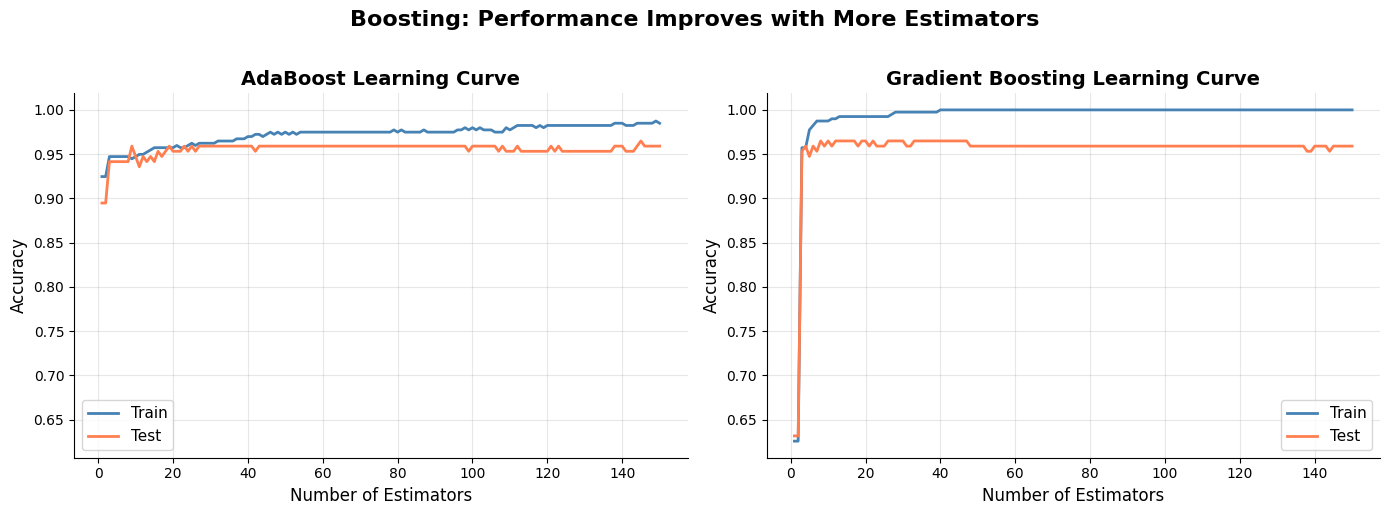

In [ ]:
# --- Plot ---
estimator_range = range(1, n_estimators + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# AdaBoost
ax1.plot(estimator_range, ada_train_scores, color='steelblue',
         linewidth=2, label='Train')
ax1.plot(estimator_range, ada_test_scores, color='coral',
         linewidth=2, label='Test')
ax1.set_xlabel('Number of Estimators', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('AdaBoost Learning Curve', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(labelsize=10)

# Gradient Boosting
ax2.plot(estimator_range, gb_train_scores, color='steelblue',
         linewidth=2, label='Train')
ax2.plot(estimator_range, gb_test_scores, color='coral',
         linewidth=2, label='Test')
ax2.set_xlabel('Number of Estimators', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Gradient Boosting Learning Curve', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.tick_params(labelsize=10)

# Match y-axis limits
y_lo = min(ax1.get_ylim()[0], ax2.get_ylim()[0])
y_hi = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
ax1.set_ylim(y_lo, y_hi)
ax2.set_ylim(y_lo, y_hi)

fig.suptitle('Boosting: Performance Improves with More Estimators',
             fontsize=16, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig('boosting_learning_curves.png', dpi=200, bbox_inches='tight')
plt.show()

---
# Section 6: Comprehensive Model Comparison

## Final Comparison: All Methods

Let's compare all the tree-based methods we've explored.

In [ ]:
# Comprehensive comparison
all_models = {
    'Decision Tree (pruned)': dt_pruned,
    'Decision Tree (full)': dt_full,
    'Bagging': bagging,
    'Random Forest': rf,
    'AdaBoost': ada,
    'Gradient Boosting': gb
}

# Add XGBoost if available
if xgb_available:
    all_models['XGBoost'] = xgb

print("="*60)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*60)
print(f"{'Model':<25} {'Train Acc':>12} {'Test Acc':>12} {'Gap':>10}")
print("-"*60)

comparison_results = []
for name, model in all_models.items():
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    gap = train_acc - test_acc
    comparison_results.append({'name': name, 'train': train_acc, 'test': test_acc})
    print(f"{name:<25} {train_acc:>12.3f} {test_acc:>12.3f} {gap:>10.3f}")

COMPREHENSIVE MODEL COMPARISON
Model                        Train Acc     Test Acc        Gap
------------------------------------------------------------
Decision Tree (pruned)           0.783        0.732      0.051
Decision Tree (full)             1.000        0.743      0.257
Bagging                          0.979        0.820      0.159
Random Forest                    0.965        0.808      0.156
AdaBoost                         0.622        0.623     -0.000
Gradient Boosting                0.801        0.768      0.033
XGBoost                          0.820        0.775      0.045


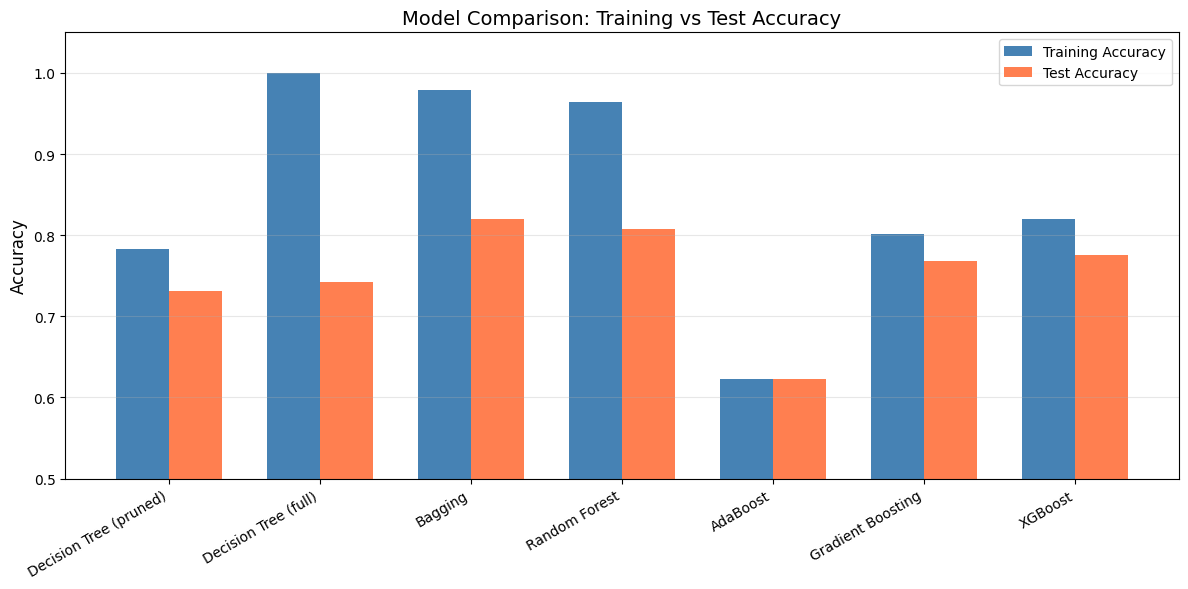

In [ ]:
# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))

names = [r['name'] for r in comparison_results]
train_accs = [r['train'] for r in comparison_results]
test_accs = [r['test'] for r in comparison_results]

x = np.arange(len(names))
width = 0.35

bars1 = ax.bar(x - width/2, train_accs, width, label='Training Accuracy', color='steelblue')
bars2 = ax.bar(x + width/2, test_accs, width, label='Test Accuracy', color='coral')

ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Model Comparison: Training vs Test Accuracy', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(names, rotation=30, ha='right')
ax.legend()
ax.set_ylim(0.5, 1.05)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

---
# Section 7: Feature Importance Comparison

## Comparing Feature Importance Across Models

Different ensemble methods may rank features differently. Let's compare.

In [ ]:
# Get feature importances from different models
importance_models = {
    'Decision Tree': dt_pruned.feature_importances_,
    'Random Forest': rf.feature_importances_,
    'Gradient Boosting': gb.feature_importances_
}

# Create comparison DataFrame
importance_df = pd.DataFrame(importance_models, index=feature_names)

# Show top 10 features for each model
print("Top 10 Features by Model:")
print("=" * 70)
for model_name in importance_models.keys():
    top_features = importance_df[model_name].sort_values(ascending=False).head(10)
    print(f"\n{model_name}:")
    for i, (feat, imp) in enumerate(top_features.items(), 1):
        print(f"  {i:2d}. {feat:30s}: {imp:.4f}")

Top 10 Features by Model:

Decision Tree:
   1. Elevation                     : 0.5722
   2. Horizontal_Distance_To_Fire_Points: 0.0634
   3. Horizontal_Distance_To_Roadways: 0.0553
   4. Horizontal_Distance_To_Hydrology: 0.0385
   5. Hillshade_Noon                : 0.0342
   6. Vertical_Distance_To_Hydrology: 0.0279
   7. Wilderness_Area_0             : 0.0250
   8. Soil_Type_1                   : 0.0204
   9. Soil_Type_3                   : 0.0199
  10. Hillshade_9am                 : 0.0188

Random Forest:
   1. Elevation                     : 0.2473
   2. Horizontal_Distance_To_Roadways: 0.0871
   3. Horizontal_Distance_To_Fire_Points: 0.0773
   4. Horizontal_Distance_To_Hydrology: 0.0566
   5. Vertical_Distance_To_Hydrology: 0.0530
   6. Aspect                        : 0.0530
   7. Hillshade_Noon                : 0.0521
   8. Hillshade_3pm                 : 0.0487
   9. Hillshade_9am                 : 0.0483
  10. Slope                         : 0.0416

Gradient Boosting:
   1. El

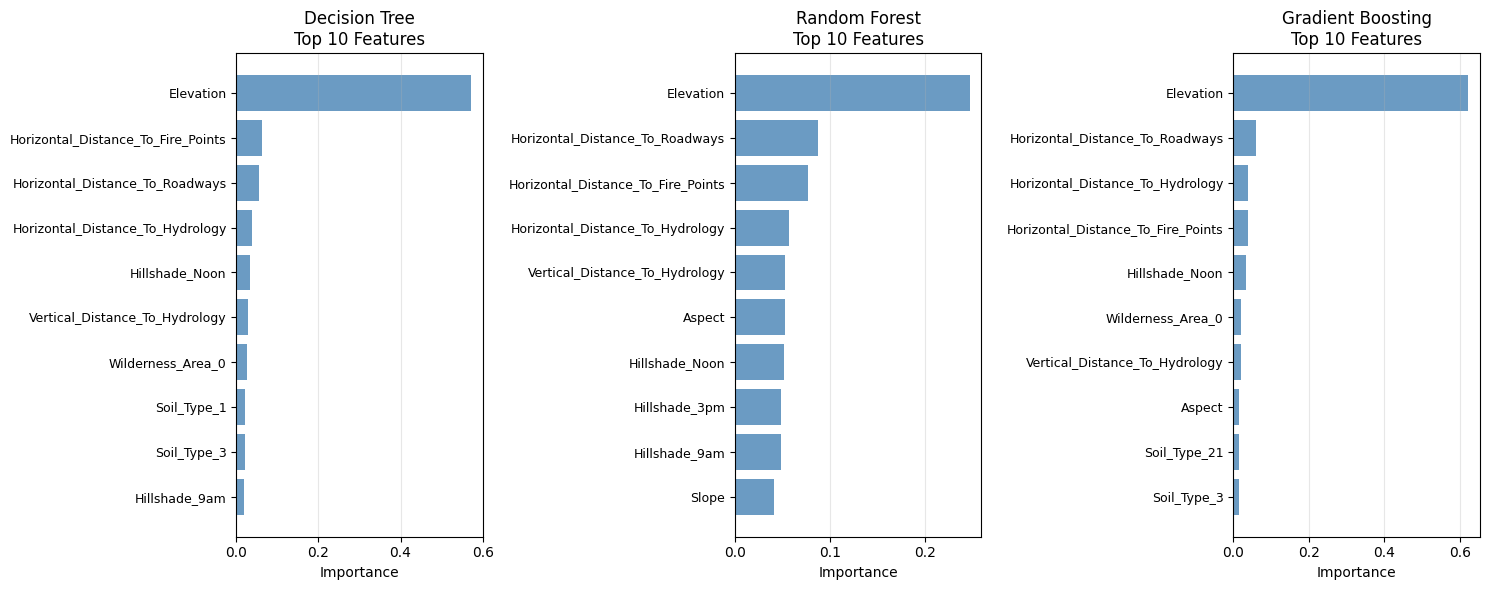

In [ ]:
# Visualize top features comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

for ax, (model_name, importances) in zip(axes, importance_models.items()):
    indices = np.argsort(importances)[::-1][:10]

    ax.barh(range(10), importances[indices], color='steelblue', alpha=0.8)
    ax.set_yticks(range(10))
    ax.set_yticklabels([feature_names[i] for i in indices], fontsize=9)
    ax.set_xlabel('Importance')
    ax.set_title(f'{model_name}\nTop 10 Features')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

---
# Summary

**Key Takeaways:**

1. **Overfitting**: Decision trees easily overfit as depth increases
   - Training accuracy continues to improve
   - Test accuracy plateaus or decreases
   
2. **Pruning**: Hyperparameters like `max_depth`, `min_samples_split` help control overfitting

3. **Ensembles**: Combining multiple trees significantly improves performance
   - **Bagging/Random Forests**: Reduce variance through averaging
   - **Boosting**: Reduce bias and variance through sequential learning
   
4. **Feature Importance**: Different models may rank features differently
   - Ensemble methods provide more stable importance estimates
   - Important for model interpretation and feature selection

5. **Practical Tips**:
   - Start with Random Forest for a robust baseline
   - Use Gradient Boosting/XGBoost for maximum performance
   - Always use cross-validation for model selection
   - Monitor train/test gap to detect overfitting

**Next Steps:**
- Try these methods on your own datasets
- Experiment with hyperparameter tuning using `GridSearchCV`
- Explore SHAP values for detailed feature interpretability
- Learn XGBoost and LightGBM for production systems